In [1]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
import json
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import numpy as np

%matplotlib inline

import os
parent = os.path.dirname(os.path.abspath("__file__"))

In [2]:
api = sj.Shioaji()

api.login('F128497445', '89118217k')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [3]:
from typing import Callable, List
from enum import Enum

from datetime import datetime, timedelta

from typing import List
from copy import deepcopy

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class BaseData(AttrDict):
    
    def __init__(self, *args, **kwargs):
        super(BaseData, self).__init__(*args, **kwargs)
        
class TickData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(TickData, self).__init__(*args, **kwargs)
        
class BarData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(BarData, self).__init__(*args, **kwargs)

class TradeMode(Enum):
    """
    交易模式
    """
    REALTIME = '實盤交易'
    SIMULATION = '模擬交易'
    BACKTEST = '回測'
    BACKTESTINTRADAY = '日內回測'

# 資料格式 (RealTime)
class Interval(Enum):
    """
    資料頻率
    """
    TICK = '逐筆'
    MINUTE = '分K'
    HOUR = '小時K'
    DAILY = '日K'

class BarGenerator:
    """
    For:
    1. generateing x minute bar/x hour bar data from tick data

    Notice:
    1. x can be any number
    """

    def __init__(self, ticker: str, interval: Interval = Interval.MINUTE, window: int = 5,
                 trademode: TradeMode = TradeMode.REALTIME, 
                 callback: Callable = None, size=15, date=datetime.today()):
        """
        Constructor
        """
        self.ticker = ticker
        self.interval = interval
        self.window = window
        self._trademode = trademode
        self.callback = callback

        self.date = date
        self.setupBarCycle(interval, window)
        self.bars: List[BarData] = []
        self.inited = False
        self.barCount = 0
        self.size = size

    def setupBarCycle(self, interval, window) -> None:
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            self.current = self.date.replace(hour=8,minute=45,second=0,microsecond=0)#datetime.now().replace(second=0)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            self.current = 84500
#         print(self.current)
        self._intervalCycle(interval, window)

    def _intervalCycle(self, interval: Interval, window: int):
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            if interval == Interval.MINUTE:
                self.cycle = timedelta(seconds=60 * window)
            elif interval == Interval.HOUR:
                self.cycle = timedelta(seconds=60 * 60 * window)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            if interval == Interval.MINUTE:
                self.cycle = 100 * window
            elif interval == Interval.HOUR:
                self.cycle = 100 * 100 * window

    def updateBar(self, tick: TickData):
        try:
            if self._trademode == TradeMode.BACKTESTINTRADAY:
                return self._updateBarBacktest(tick)
            return self._updateBar(tick)
        except:
            raise

    def _updateBar(self, tick: TickData):
        try:
            try:
                time, close, volume = tick.time, tick.close, tick.volume
            except:
                # print(tick)
                time, close, volume = tick['time'], tick['close'], tick['volume']
#             print(tick, '\t', self.current)
            if not self.bars or time > self.current:
                self.bars.append(self._createNewBar(time, close, volume))
                self._updateCurBarTime()
                if len(self.bars) >= self.size:
                    self.inited = True
                if len(self.bars) > 1:
#                     print(self.bars[-2])
                    return self.bars[-2]
                    if self.callback:
                        self.callback(self.bars[-2])
            else:
                self._updateCurBar(close, volume)
        except Exception as e:
            print(e)
            raise

    def _updateBarBacktest(self, tick: TickData):
        time, close, volume = tick.time, tick.close, tick.volume
        if not self.bars or time > self.current:
            self.bars.append(self._createNewBar(time, close, volume))
            self._updateCurBarTime()
            if len(self.bars) >= self.size:
                self.inited = True
            if len(self.bars) > 1:
                self.callback(self.bars[-2])
        else:
            self._updateCurBar(close, volume)
            
    def _createNewBar(self, time, close, volume):
        return BarData(
                    symbol=self.ticker,
                    time=time,
                    open=close,
                    high=close,
                    low=close,
                    close=close,
                    volume=volume
                )
    
    def _updateCurBar(self, close, volume):
        curBar = self.bars[-1]
        curBar.high = max(curBar.high, close)
        curBar.low = min(curBar.low, close)
        curBar.close = close
        curBar.volume += volume
        self.bars[-1] = curBar

    def _updateCurBarTime(self):
        self.current += self.cycle
#         if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
#             return
        if self._trademode == TradeMode.BACKTESTINTRADAY:
            timeList = self._intTolist(self.current)
            if self.interval == Interval.MINUTE:
                if timeList[1] >= 60:
                    timeList[0] += 1
                    timeList[1] -= 60
            if timeList[0] >= 24:
                timeList[0] -= 24
            self.current = int(''.join([str(int(x)) for x in timeList]))

    def _intTolist(self, t):
        ss = t % 100
        t /= 100
        mm = t % 100
        hh = t / 100
        return [int(hh), int(mm), int(ss)]

    @property
    def closes(self):
        return [getattr(bar, 'close') for bar in self.bars][:-1]

    @property
    def opens(self):
        return [getattr(bar, 'open') for bar in self.bars][:-1]

    @property
    def highs(self):
        return [getattr(bar, 'high') for bar in self.bars][:-1]

    @property
    def lows(self):
        return [getattr(bar, 'low') for bar in self.bars][:-1]

    @property
    def volumes(self):
        return [getattr(bar, 'volume') for bar in self.bars][:-1]
    
    @property
    def times(self):
        return [getattr(bar, 'time') for bar in self.bars][:-1]

In [4]:
def getNearbyCode(td:datetime):
    month = getNearbyMonth(td)
    return [chr(m+65-1), chr(m+65-1+12)]
    
def getNearbyMonth(td: datetime = None):
    if not td:
        td = datetime.today()
    month = td.month
    if isTimetoMaturity(td): 
        month += 1
        if month > 12:
            month = 1
    return month

def getExistsContract(date: datetime, strikes:list, symbol:str='TXF', months:int=3) -> list:
    global call_code_map, put_code_map, opt_ticker_map
    opt_ticker = opt_ticker_map[symbol]
    Conti_Ms = getExistsContractMonth(date)
    contracts = []
    y = date.year
    next_y = y + 1
    for strike in strikes:
        strike = StrikeFill(strike, symbol)
        
        for m in Conti_Ms[:months]:
            call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(y)[-1]}'
            put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(y)[-1]}'
            if 12 in Conti_Ms[1:3]:
                if m < 12:
                    call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(next_y)[-1]}'
                    put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(next_y)[-1]}'
            contracts.extend([call_ticker, put_ticker])
    return contracts

def getExistsContractMonth(date):
    month = getNearbyMonth(date)
    conti_Ms = [x if x <= 12 else x - 12 for x in range(month, month + 3)]
    if conti_Ms[-1] in [3, 4, 5]: # 3個連續月份的最後一個月是3或4或5，判斷連續季月月份，以下雷同
        conti_Ms.extend([6, 9, 12])
    elif conti_Ms[-1] in [6, 7, 8]:
        conti_Ms.extend([9, 12, 3])
    elif conti_Ms[-1] in [9, 10, 11]:
        conti_Ms.extend([12, 3, 6])
    elif conti_Ms[-1] in [12, 1, 2]:
        conti_Ms.extend([3, 6, 9])
    return conti_Ms

def isTimetoMaturity(td):
    thirdWendesday = getThirdWendesday(td)
    if td.strftime('%Y%m%d') >= thirdWendesday.strftime('%Y%m%d'): 
        return True
    return False

def getThirdWendesday(td):
    week = 2
    first_wendesday = getFirstWendesday(td)
    return first_wendesday + timedelta(week * 7)

def getFirstWendesday(td):
    first_day = datetime(td.year, td.month, 2)
    if first_day.weekday() <= 2:
        adj_days = 2 - first_day.weekday()
    else:
        adj_days = 9 - first_day.weekday()
    return first_day + timedelta(adj_days)

def getContiCode(td:datetime):
    m = getNearbyMonth(td)
    next_m = (m + 1) % 12
    if not next_m:
        next_m = 12
    if m+1 > 12: 
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year + 1)[-1]]
    else:
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year)[-1]]
    

In [5]:
def ReadData(date):
    data_path = os.path.join(parent, "HistoricData", "MXF")
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
#     for k, v in dfs.items():
    tdStr = date.strftime("%Y-%m-%d")
    try:
        with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
            df.datetime = pd.to_datetime(df.datetime)
        return df.set_index('datetime')
    except:
        return pd.DataFrame()
    
def WriteData(date, df):
    data_path = os.path.join(parent, "HistoricData", "MXF")
    tdStr = date.strftime("%Y-%m-%d")
    with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'w') as f:
        df = df.reset_index()
        df.datetime = df.datetime.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"))
        json.dump(list(df.T.to_dict().values()), f)

def GetPairData(api, date:datetime=datetime(2021,11,5)):
    df = ReadData(date)
    if not df.empty:
        return df
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby.code = "MXF"+last_code[0]
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %H:%M:%S.")+str(x)[10:16])
    df_nearby['datetime'] = pd.to_datetime(df_nearby['datetime'])

    df_nearby = df_nearby.set_index('datetime')
    WriteData(date, df_nearby)
    return df_nearby

def GetPairDataBar(api, date:datetime=datetime(2021,11,5)):
    df = ReadData(date)
    if not df.empty:
        return df
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby.code = "MXF"+last_code[0]
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %H:%M:%S.")+str(x)[10:16])
    df_nearby['datetime'] = pd.to_datetime(df_nearby['datetime'])

    df_nearby = df_nearby.set_index('datetime')
    return df_nearby

In [79]:
def Backtest(df, takeprofit = 20, stop_loss = 40, gap_threshold = 0.1, 
             inverse_threshold=80, pre_day_close = None, window=5, ma_len=5,
             date=datetime(2022,2,18)):

    setup_param = False
    entry = sig = pos = 0
    interval_h = 0 # 區間高點
    interval_l = 99999 # 區間低點
    gap = 0
    
    result = []
    pre_close = None
    total_pnl = 0
    total_win = 0
    total_loss = 0
    win_trade = 0
    loss_trade = 0
    record = {}
    end_Trade = False
    tmp_min_pnl = tmp_max_pnl = min_pnl = max_pnl = 0
    tmp_sl = 10 # stoploss
    loss_num = 0
    max_unreal = 0
    max_price = 0
    min_price = 99999
    entry = 0
    zero_trade = 0
    sig_inverse = 1
    critical_h = critical_l = None
    prefer_short = prefer_long = False
    check_dir = False
    bar_ratio = 2
    mini_bar_width = 10
    if window == 15:
        bar_ratio = 1
        mini_bar_width = 20
    follow_trend = False
#     if pre_day_close:
#         critical_h = pre_day_close * 1.007
#         critical_l = pre_day_close * 0.993
#         print(critical_h, critical_l)
    barG = BarGenerator(ticker="MXF", window=window, date=date)
    MA5 = []
    for row in df.itertuples():
#         print(row)
        tick = TickData(time=row.Index, close=row.close,volume=row.volume)
#         print(tick)
        update_bar = barG.updateBar(tick)
        if len(barG.bars) <= ma_len:
# #         if row.Index <= row.Index.replace(hour=9, minute=30, second=0, microsecond=0):
            continue
        if update_bar:
            MA5.append(np.mean(barG.closes[-ma_len:]))
        if len(MA5) <= 1:
            continue
#         if not setup_param:
# #             print(barG.highs[:10])
# #             print(barG.lows[:10])
            
#             interval_h = min(barG.highs[:10]) # max([max(bar.open, bar.close) for bar in barG.bars[:10]]) # max(barG.highs[:10])
#             interval_l = max(barG.lows[:10]) # min([min(bar.open, bar.close) for bar in barG.bars[:10]]) # min(barG.lows[:10])
#             mid_interval = (interval_h + interval_l) / 2
#             gap = abs(interval_h - interval_l)
#             gap_ratio = gap / interval_l
#             print(interval_h, interval_l, mid_interval, gap, gap_ratio)
#             setup_param = True
#             stop_loss = abs(interval_h - mid_interval)
#             print(f"StopLoss Points : {stop_loss}")
#             continue
        if row.Index <= row.Index.replace(hour=13, minute=0, second=0, microsecond=0) and not end_Trade:
            if sig == 0 and pos == 0 and not end_Trade:
                if update_bar:
                    if barG.bars[-3].open > barG.bars[-3].close and update_bar.close > update_bar.open:
                        if abs(barG.bars[-3].close - update_bar.open) <= 5:
                            sig = 1
#                             follow_trend = True
                    elif barG.bars[-3].open < barG.bars[-3].close and update_bar.close < update_bar.open:
                        if abs(barG.bars[-3].close - update_bar.open) <= 5:
                            sig = -1
#                             follow_trend = True
#                     if update_bar.close > MA5[-1] and MA5[-1] > MA5[-2]:
#                         sig = 1
#                         follow_trend = True
#                         print("Entry Long With FollowTrend")
#                     elif update_bar.close < MA5[-1] and MA5[-1] < MA5[-2]:
#                         sig = -1
#                         follow_trend = True
#                         print("Entry Short With FollowTrend")
#                     elif barG.closes[-2] <= MA5[-2] and barG.closes[-1] > MA5[-1]:
#                         sig = 1
#                         print("Entry Long With Cross Over")
#                     elif barG.closes[-2] >= MA5[-2] and barG.closes[-1] < MA5[-1]:
#                         sig = -1
#                         print("Entry short With Cross Under")
#                     pre_up_shadow_line = pre_dn_shadow_line = 0
# #                     if pre_bar:
# #                         pre_up_shadow_line = abs(max(update_bar.open,update_bar.close) - update_bar.high)
# #                         pre_dn_shadow_line = abs(min(update_bar.open,update_bar.close) - update_bar.low)
                        
#                     up_shadow_line = abs(max(update_bar.open,update_bar.close) - update_bar.high)
#                     dn_shadow_line = abs(min(update_bar.open,update_bar.close) - update_bar.low)
#                     real_bar = abs(max(update_bar.open-update_bar.close,mini_bar_width))
# #                     if pre_up_shadow_line and pre_dn_shadow_line:
# #                         if pre_up_shadow_line > pre_dn_shadow_line and upda:
                            
#                     if up_shadow_line / real_bar >= bar_ratio and dn_shadow_line / real_bar >= bar_ratio:
#                         if up_shadow_line > dn_shadow_line:
#                             sig = -1
#                         elif up_shadow_line < dn_shadow_line:
#                             sig = 1
#                     elif abs(min(update_bar.open,update_bar.close) - update_bar.low) / abs(max(update_bar.open-update_bar.close,mini_bar_width)) >= bar_ratio:
#                         sig = 1
#                     elif abs(max(update_bar.open,update_bar.close) - update_bar.high) / abs(max(update_bar.open-update_bar.close,mini_bar_width)) >= bar_ratio:
#                         sig = -1
#                     pre_bar = update_bar
#                     if update_bar.close >= mid_interval:# and gap < .01:
#                         print("Entry with Cross Over mid_interval")
#                         print(update_bar)
#                         sig = 1
#                     if update_bar.close >= interval_h:
#                         print("Entry with Cross Over High")
#                         print(update_bar)
#                         sig = 1
#                     elif update_bar.close <= mid_interval:# and gap < .01:
#                         print("Entry with Cross Under mid_interval")
#                         print(update_bar)
#                         sig = -1
#                     elif update_bar.close <= interval_l:
#                         print("Entry with Cross Under Low")
#                         print(update_bar)
#                         sig = -1
#                     if update_bar.low < interval_l and update_bar.close > interval_l and update_bar.close > update_bar.open:
#                         print("Entry with Turn Over Low")
#                         print(update_bar)
#                         sig = 1
                        
                if sig != 0:# and pos == 0:
                    print(f"{row.Index}, PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    if sig > 0:
#                         if row.ask_price >= row.close:
                        entry  = row.ask_price
                        stop_loss = entry - barG.lows[-2]
                        if follow_trend:
                            stop_loss = (entry - min(barG.lows[-ma_len:-1]))
#                             print(en)
                    elif sig < 0:
#                         if row.bid_price <= row.close:
                        entry  = row.bid_price
                        stop_loss = -(entry - barG.highs[-2])
                        if follow_trend:
                            stop_loss = -(entry - max(barG.highs[-ma_len:-1]))
                    if entry:
                        pos = sig
                        
#                         stop_loss = interval_h
#                         if sig > 0:
#                             stop_loss = interval_l
                        print(f'Entry : {entry}, pos : {pos} at ts : {row.Index}, Close = {row.close}, StopLoss = {stop_loss}')
                    sig = 0
            if sig == 0 and pos != 0:
                if pos < 0:
                    exit = min(row.ask_price, row.close)
#                     min_price = min(min_price, row.close)
                elif pos > 0:
                    exit = max(row.bid_price, row.close)
#                     max_price = max(max_price, row.close)
                
                tmp_pnl = (exit - entry) * pos
                tmp_max_pnl = max(tmp_max_pnl, tmp_pnl)
                tmp_min_pnl = min(tmp_min_pnl, tmp_pnl)
                if follow_trend and 0:
#                     if tmp_max_pnl >= takeprofit / 2:
                    if update_bar:
                        
                        if pos > 0 and update_bar.close < min(barG.lows[-ma_len:-1]):
                            sig = -pos
                        elif pos < 0 and update_bar.close > max(barG.highs[-ma_len:-1]):
                            sig = -pos
#                         elif tmp_max_pnl >= takeprofit / 2:
#                             if tmp_pnl <= tmp_max_pnl - takeprofit:
#                                 sig = -pos
#                         elif tmp_pnl <= -stop_loss:
#                             sig = -pos
                else:
                    if tmp_pnl >= takeprofit:
                        sig = -pos
#                 if update_bar:
#                     if update_bar.close >= interval_h and pos < 0:
#                         sig = -pos
#                     elif update_bar.close <= interval_l and pos > 0:
#                         sig = -pos
#                     if update_bar:
                    if tmp_pnl <= -stop_loss:
#     #                         if update_bar.close <= (entry - stop_loss) * pos:
#                             print(update_bar.close, entry, stop_loss, entry - stop_loss)
                    
                        sig = -pos
#                     if update_bar.close > MA5[-1] and MA5[-1] > MA5[-2]:
#                         sig = 1
#                     elif update_bar.close < MA5[-1] and MA5[-1] < MA5[-2]:
#                         sig = -1
                    if barG.closes[-2] <= MA5[-2] and barG.closes[-1] > MA5[-1] and pos < 0:
                        sig = -pos
                    if barG.closes[-2] >= MA5[-2] and barG.closes[-1] < MA5[-1] and pos > 0:
                        sig = -pos
                if sig != 0:
                    print(f"Max Pnl : {tmp_max_pnl}, Min Pnl : {tmp_min_pnl}")
                    tmp_min_pnl = tmp_max_pnl = 0
                    print(f"PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    pnl = (exit - entry) * pos - 2
                    total_pnl += pnl #- 2
                    if pnl > 0:
                        win_trade += 1
                        total_win += pnl
                    elif pnl < 0:
                        loss_trade += 1
                        total_loss += pnl
                    else:
                        zero_trade += 1
                    print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                    max_unreal = entry = exit = pos = sig = 0
                    max_pnl = max(total_pnl, max_pnl)
                    min_pnl = min(total_pnl, min_pnl)
                    max_price = 0
                    min_price = 99999
                    tmp_max_pnl = tmp_min_pnl = 0
                    follow_trend = False
#                 if total_pnl > 0 or (loss_trade >= 2 and not win_trade) or (loss_trade > 2 and win_trade):
#                 if total_pnl > 0 :#loss_trade:
#                     end_Trade = True
        else:
            if not pos:continue
            if row.Index <= row.Index.replace(hour=13, minute=30, second=0, microsecond=0):
                if pos < 0:
                    exit = min(row.ask_price, row.close)
#                     min_price = min(min_price, row.close)
                elif pos > 0:
                    exit = max(row.bid_price, row.close)
#                     max_price = max(max_price, row.close)
                
                tmp_pnl = (exit - entry) * pos
                tmp_max_pnl = max(tmp_max_pnl, tmp_pnl)
                tmp_min_pnl = min(tmp_min_pnl, tmp_pnl)
                if follow_trend:
                    if update_bar:
                        if pos > 0 and update_bar.close < min(barG.lows[-ma_len:-1]):
                            sig = -pos
                        elif pos < 0 and update_bar.close > max(barG.highs[-ma_len:-1]):
                            sig = -pos
                else:
                    if tmp_pnl >= takeprofit:
                        sig = -pos
                    if update_bar:
                        if tmp_pnl <= -stop_loss:
                            print(update_bar.close, entry, stop_loss, entry - stop_loss)
                            sig = -pos
            else:
                if pos < 0:
                    exit = row.ask_price
                elif pos > 0:
                    exit = row.bid_price
                sig = -pos

            if sig != 0:
                pnl = (exit - entry) * pos - 2
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                elif pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                else:
                    zero_trade += 1
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                max_unreal = entry = exit = pos = sig = 0
                max_pnl = max(total_pnl, max_pnl)
                min_pnl = min(total_pnl, min_pnl)
                max_price = 0
                min_price = 99999
#                 if total_pnl > 0 or (loss_trade >= 2 and not win_trade) or (loss_trade > 2 and win_trade):
#                 if loss_trade:
#                     end_Trade = True
#         print(pre_close, row.close)
        pre_close = row.close
#         print(pre_close, row.close, "\n")

    avg_win = total_win / win_trade if win_trade else 0
    avg_loss = total_loss / loss_trade if loss_trade else 0
    Q = avg_win / abs(avg_loss) if avg_loss else 0
    total_trade = win_trade + loss_trade + zero_trade
    Pw = win_trade / total_trade if total_trade else 0
    Ev = Q * Pw - (1 - Pw)
    Avg_PnL = total_pnl / total_trade if total_trade else 0
    print(f"------------Strategy Result at {row.Index.strftime('%Y-%m-%d')}------------")
    print(f'Total PnL : {total_pnl}')
    print(f'Avg Win : {avg_win}')
    print(f'Num Win : {win_trade}')
    print(f'Avg Loss : {avg_loss}')
    print(f'Num Loss : {loss_trade}')
    print(f'Avg PnL : {Avg_PnL}')
    print(f'G/L : {Q}, Pw : {Pw}, Expected Value : {Ev}')
    print(f'Max Pnl : {max_pnl}, Min Pnl : {min_pnl}\n')
    print("===================End BackTest===================\n")

    return (total_pnl, avg_win, win_trade, avg_loss, loss_trade, Avg_PnL, Q, Pw, Ev)

In [46]:
date = datetime(2022,1,24)
df = GetPairData(api, date=date)

In [7]:
def PlotKBar(api, date=datetime(2021,2,18), window=5):
    df = GetPairData(api, date=date)
    barG = BarGenerator(ticker="MXF", window=window, date=date)
    for row in df.itertuples():
        tick = TickData(time=row.Index, close=row.close,volume=row.volume)
        update_bar = barG.updateBar(tick)

    bar_df = pd.DataFrame(barG.bars)
    bar_df['MA5'] = bar_df.close.rolling(5).mean()

    fig = go.Figure(data=[go.Candlestick(x=bar_df.time,
                    open=bar_df.open,
                    high=bar_df.high,
                    low=bar_df.low,
                    close=bar_df.close)])
    fig.add_trace(
        go.Scatter(
            x=bar_df.time,
            y=bar_df.MA5
        ))

    fig.show()

In [56]:
PlotKBar(api, datetime(2021,1,5), window=5)

In [81]:
date = datetime(2021,1,11)
# dfs[date] = GetPairData(api, date=date)
# dfs[date].close.plot(figsize=(12,8))
df = GetPairData(api, date)
result = Backtest(df, takeprofit = 5, stop_loss = 8, gap_threshold=0.3, inverse_threshold=80, pre_day_close = 17896, date=date,window=5, ma_len=3)

2021-01-11 09:35:00.002000, PreClose : 15445.0, Close : 15444.0, Ask : 15447.0, Bid : 15445.0
Entry : 15445.0, pos : -1 at ts : 2021-01-11 09:35:00.002000, Close = 15444.0, StopLoss = 65.0
Max Pnl : 5.0, Min Pnl : -1.0
PreClose : 15441.0, Close : 15440.0, Ask : 15442.0, Bid : 15441.0
Exit : 15440.0, pnl : 3.0, total_pnl : 3.0 at ts : 2021-01-11 09:35:02.017000, Close = 15440.0

2021-01-11 09:50:00.138000, PreClose : 15453.0, Close : 15452.0, Ask : 15454.0, Bid : 15452.0
Entry : 15454.0, pos : 1 at ts : 2021-01-11 09:50:00.138000, Close = 15452.0, StopLoss = 17.0
Max Pnl : 5.0, Min Pnl : -15.0
PreClose : 15458.0, Close : 15459.0, Ask : 15459.0, Bid : 15457.0
Exit : 15459.0, pnl : 3.0, total_pnl : 6.0 at ts : 2021-01-11 09:50:31.474000, Close = 15459.0

2021-01-11 10:00:00.005000, PreClose : 15429.0, Close : 15427.0, Ask : 15428.0, Bid : 15427.0
Entry : 15427.0, pos : -1 at ts : 2021-01-11 10:00:00.005000, Close = 15427.0, StopLoss = 48.0
Max Pnl : 5.0, Min Pnl : -17.0
PreClose : 15423.0

In [114]:
from concurrent.futures import ThreadPoolExecutor

In [84]:
results = {}
dfs = {}
# with ThreadPoolExecutor(4) as executors:
    
for date in pd.date_range(datetime(2021,1,4), datetime(2022,3,18)):
    try:
        if date not in dfs.keys():
            dfs[date] = GetPairData(api, date=date)
        if dfs[date] is None or dfs[date].empty:
            print(f'===============No Data on {date.strftime("%Y-%m-%d")}===============')
            continue
        print(f'===============Backtest {date.strftime("%Y-%m-%d")}===============')
        results[date] = Backtest(dfs[date], takeprofit = 10, stop_loss = 8, gap_threshold=0.3, inverse_threshold=80, pre_day_close = 17896, date=date, window=5)
#         results[date] = Backtest(dfs[date], takeprofit = 8, stoploss = 30, gap_threshold=0.2,date=date)
        time.sleep(0.5)
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        pass

===============Backtest 2021-01-04===============
2021-01-04 09:15:00.072000, PreClose : None, Close : 14708.0, Ask : 14708.0, Bid : 14707.0
Entry : 14707.0, pos : -1 at ts : 2021-01-04 09:15:00.072000, Close = 14708.0, StopLoss = 11.0
Max Pnl : 10.0, Min Pnl : -10.0
PreClose : 14698.0, Close : 14697.0, Ask : 14699.0, Bid : 14698.0
Exit : 14697.0, pnl : 8.0, total_pnl : 8.0 at ts : 2021-01-04 09:18:03.226000, Close = 14697.0

2021-01-04 09:25:00.020000, PreClose : 14684.0, Close : 14685.0, Ask : 14685.0, Bid : 14684.0
Entry : 14685.0, pos : 1 at ts : 2021-01-04 09:25:00.020000, Close = 14685.0, StopLoss = 34.0
Max Pnl : 10.0, Min Pnl : -1.0
PreClose : 14694.0, Close : 14695.0, Ask : 14694.0, Bid : 14693.0
Exit : 14695.0, pnl : 8.0, total_pnl : 16.0 at ts : 2021-01-04 09:26:04.124000, Close = 14695.0

2021-01-04 09:35:00.156000, PreClose : 14721.0, Close : 14721.0, Ask : 14722.0, Bid : 14721.0
Entry : 14721.0, pos : -1 at ts : 2021-01-04 09:35:00.156000, Close = 14721.0, StopLoss = 12.0

Max Pnl : 10.0, Min Pnl : -10.0
PreClose : 14902.0, Close : 14901.0, Ask : 14903.0, Bid : 14902.0
Exit : 14901.0, pnl : 8.0, total_pnl : -44.0 at ts : 2021-01-05 11:57:57.078000, Close = 14901.0

2021-01-05 12:00:00.672000, PreClose : 14916.0, Close : 14915.0, Ask : 14916.0, Bid : 14914.0
Entry : 14914.0, pos : -1 at ts : 2021-01-05 12:00:00.672000, Close = 14915.0, StopLoss = 5.0
Max Pnl : 10.0, Min Pnl : -2.0
PreClose : 14905.0, Close : 14904.0, Ask : 14905.0, Bid : 14904.0
Exit : 14904.0, pnl : 8.0, total_pnl : -36.0 at ts : 2021-01-05 12:05:11.193000, Close = 14904.0

2021-01-05 12:35:00.045000, PreClose : 14874.0, Close : 14874.0, Ask : 14874.0, Bid : 14872.0
Entry : 14872.0, pos : -1 at ts : 2021-01-05 12:35:00.045000, Close = 14874.0, StopLoss = 24.0
Max Pnl : 0, Min Pnl : -23.0
PreClose : 14892.0, Close : 14892.0, Ask : 14893.0, Bid : 14892.0
Exit : 14892.0, pnl : -22.0, total_pnl : -58.0 at ts : 2021-01-05 12:40:00.070000, Close = 14892.0

------------Strategy Result at 2021-0

2021-01-07 09:25:00.227000, PreClose : 15073.0, Close : 15072.0, Ask : 15073.0, Bid : 15072.0
Entry : 15072.0, pos : -1 at ts : 2021-01-07 09:25:00.227000, Close = 15072.0, StopLoss = 35.0
Max Pnl : 10.0, Min Pnl : -23.0
PreClose : 15063.0, Close : 15062.0, Ask : 15065.0, Bid : 15064.0
Exit : 15062.0, pnl : 8.0, total_pnl : 8.0 at ts : 2021-01-07 09:29:28.721000, Close = 15062.0

2021-01-07 09:40:00.042000, PreClose : 15071.0, Close : 15072.0, Ask : 15072.0, Bid : 15071.0
Entry : 15072.0, pos : 1 at ts : 2021-01-07 09:40:00.042000, Close = 15072.0, StopLoss = 49.0
Max Pnl : 10.0, Min Pnl : -1.0
PreClose : 15080.0, Close : 15082.0, Ask : 15082.0, Bid : 15080.0
Exit : 15082.0, pnl : 8.0, total_pnl : 16.0 at ts : 2021-01-07 09:40:40.055000, Close = 15082.0

2021-01-07 10:00:00.029000, PreClose : 15092.0, Close : 15092.0, Ask : 15093.0, Bid : 15092.0
Entry : 15092.0, pos : -1 at ts : 2021-01-07 10:00:00.029000, Close = 15092.0, StopLoss = 12.0
Max Pnl : 10.0, Min Pnl : -5.0
PreClose : 1508

Max Pnl : 10.0, Min Pnl : -9.0
PreClose : 15350.0, Close : 15349.0, Ask : 15350.0, Bid : 15349.0
Exit : 15349.0, pnl : 8.0, total_pnl : -45.0 at ts : 2021-01-08 09:46:02.243000, Close = 15349.0

2021-01-08 10:10:00.189000, PreClose : 15308.0, Close : 15308.0, Ask : 15309.0, Bid : 15308.0
Entry : 15309.0, pos : 1 at ts : 2021-01-08 10:10:00.189000, Close = 15308.0, StopLoss = 45.0
Max Pnl : 10.0, Min Pnl : -6.0
PreClose : 15318.0, Close : 15319.0, Ask : 15318.0, Bid : 15317.0
Exit : 15319.0, pnl : 8.0, total_pnl : -37.0 at ts : 2021-01-08 10:10:44.461000, Close = 15319.0

2021-01-08 10:20:00.454000, PreClose : 15331.0, Close : 15331.0, Ask : 15332.0, Bid : 15331.0
Entry : 15331.0, pos : -1 at ts : 2021-01-08 10:20:00.454000, Close = 15331.0, StopLoss = 7.0
Max Pnl : 9.0, Min Pnl : -7.0
PreClose : 15337.0, Close : 15338.0, Ask : 15338.0, Bid : 15337.0
Exit : 15338.0, pnl : -9.0, total_pnl : -46.0 at ts : 2021-01-08 10:23:59.972000, Close = 15338.0

2021-01-08 10:25:00.197000, PreClose : 

Max Pnl : 6.0, Min Pnl : -9.0
PreClose : 15439.0, Close : 15440.0, Ask : 15449.0, Bid : 15447.0
Exit : 15447.0, pnl : -7.0, total_pnl : 26.0 at ts : 2021-01-11 11:45:00.122000, Close = 15440.0

2021-01-11 11:55:00.167000, PreClose : 15433.0, Close : 15433.0, Ask : 15449.0, Bid : 15447.0
Entry : 15449.0, pos : 1 at ts : 2021-01-11 11:55:00.167000, Close = 15433.0, StopLoss = 31.0
Max Pnl : 4.0, Min Pnl : -2.0
PreClose : 15441.0, Close : 15440.0, Ask : 15449.0, Bid : 15447.0
Exit : 15447.0, pnl : -4.0, total_pnl : 22.0 at ts : 2021-01-11 12:20:00.616000, Close = 15440.0

2021-01-11 12:35:00.079000, PreClose : 15406.0, Close : 15406.0, Ask : 15449.0, Bid : 15447.0
Entry : 15449.0, pos : 1 at ts : 2021-01-11 12:35:00.079000, Close = 15406.0, StopLoss = 46.0
Max Pnl : 0, Min Pnl : -2.0
PreClose : 15413.0, Close : 15412.0, Ask : 15449.0, Bid : 15447.0
Exit : 15447.0, pnl : -4.0, total_pnl : 18.0 at ts : 2021-01-11 12:45:00.113000, Close = 15412.0

2021-01-11 12:50:00.604000, PreClose : 15419

In [73]:
cum_pnl = []

for d, res in results.items():
    if res[0] <0:
        print(d, res[0])
    cum_pnl.append({"Date":d.strftime("%Y-%m-%d"), "PnL":res[0]})

2021-01-15 00:00:00 -184.0
2021-01-20 00:00:00 -112.0
2021-01-21 00:00:00 -213.0
2021-01-26 00:00:00 -181.0
2021-02-24 00:00:00 -163.0
2021-03-19 00:00:00 -113.0
2021-03-23 00:00:00 -72.0
2021-03-26 00:00:00 -222.0
2021-04-13 00:00:00 -88.0
2021-04-23 00:00:00 -60.0
2021-04-28 00:00:00 -107.0
2021-05-03 00:00:00 -240.0
2021-06-04 00:00:00 -79.0
2021-06-08 00:00:00 -52.0
2021-06-15 00:00:00 -126.0
2021-06-21 00:00:00 -154.0
2021-06-30 00:00:00 -5.0
2021-07-02 00:00:00 -51.0
2021-07-06 00:00:00 -141.0
2021-07-15 00:00:00 -102.0
2021-07-19 00:00:00 -109.0
2021-07-20 00:00:00 -143.0
2021-07-22 00:00:00 -59.0
2021-07-23 00:00:00 -64.0
2021-07-29 00:00:00 -124.0
2021-08-02 00:00:00 -150.0
2021-08-03 00:00:00 -126.0
2021-08-10 00:00:00 -100.0
2021-08-26 00:00:00 -106.0
2021-08-27 00:00:00 -147.0
2021-09-07 00:00:00 -127.0
2021-09-15 00:00:00 -126.0
2021-09-22 00:00:00 -244.0
2021-09-30 00:00:00 -99.0
2021-10-06 00:00:00 -156.0
2021-10-07 00:00:00 -151.0
2021-10-13 00:00:00 -70.0
2021-10-22 00

In [74]:
Cum_df = pd.DataFrame(cum_pnl).set_index("Date")
Cum_df["W_L"] = Cum_df['PnL'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [75]:
win_trade = (Cum_df["W_L"] > 0).sum()
loss_trade = (Cum_df["W_L"] < 0).sum()
total_win = (Cum_df[Cum_df["W_L"] > 0]["PnL"]).sum()
total_loss = (Cum_df[Cum_df["W_L"] < 0]["PnL"]).sum()
Pw = win_trade / (win_trade + loss_trade)
avg_win = total_win / win_trade
avg_loss = total_loss / loss_trade
Ev = Pw * avg_win + (1-Pw) * avg_loss
Pw, avg_win, avg_loss, Ev

(0.7942238267148014,
 15.854545454545455,
 -110.40350877192982,
 -10.126353790613722)

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date'>

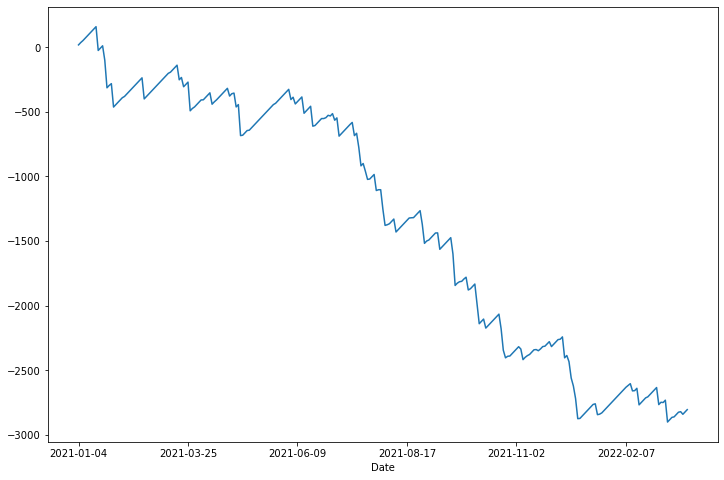

In [76]:
Cum_df["PnL"].cumsum().plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

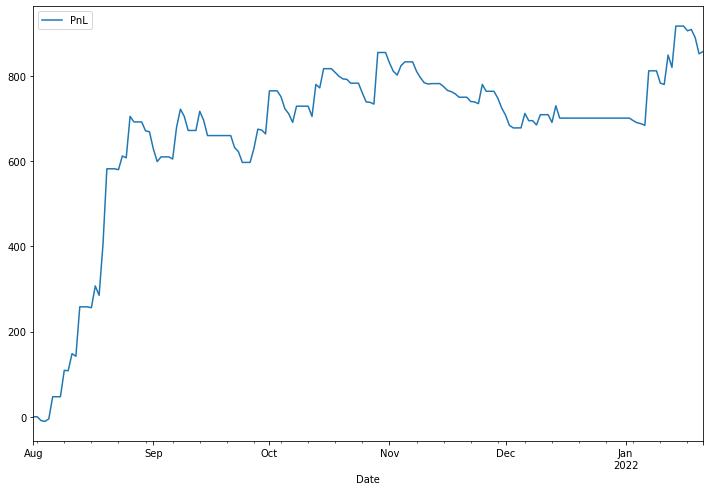

In [47]:
Cum_df.cumsum().plot(figsize=(12,8))

In [389]:
import json
data_path = os.path.join(parent, "HistoricData", "MXF")
if not os.path.isdir(data_path):
    os.makedirs(data_path)
for k, v in dfs.items():
    tdStr = k.strftime("%Y-%m-%d")
    with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'w') as f:
        v = v.reset_index()
        v.datetime = v.datetime.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"))
        json.dump(list(v.T.to_dict().values()), f)